In [ ]:
pip install datatable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import random
import string
from datetime import datetime
import time
import os
from matplotlib import pyplot as plt
import h5py
import warnings
import datatable as dt
import msgpack
import memory_profiler
from sklearn import preprocessing
import distutils
warnings.simplefilter(action='ignore', category=FutureWarning)
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

In [ ]:
os.mkdir("results")

In [ ]:
types = ['int', 'float', 'string', 'boolean', 'datetime64[ns]']
num_iterations = 10

Генерация колонок

In [ ]:
def column(column_type, length) :
  if types[column_type] == 'int' :
    return int_column(length)
  elif types[column_type] == 'float':
    return float_column(length)
  elif types[column_type] == 'boolean' :
    return boolean_column(length)
  elif types[column_type] == 'string' :
    return string_column(length)
  elif types[column_type] == 'datetime64[ns]' :
    return date_column(length)

def int_column(length) :
  column = []
  for i in range(length) :
    column.append(random.randint(-2147483648, 2147483647))
  return column

def float_column(length) :
  column = []
  for i in range(length) :
    column.append(random.uniform(-100, 100))
  return column

def boolean_column(length) :
  column = []
  for i in range(length) :
    column.append(bool(random.randint(0,1)))
  return column

def string_column(length) :
  column = []
  letters = string.ascii_lowercase
  for i in range(length) :
    column.append(''.join([random.choice(letters) for j in range(random.randint(0,10))]))
  return column

def date_column(length) :
  column = []
  for i in range(length) :
    column.append(datetime.fromtimestamp(random.randint(0, round(time.time()))).strftime("%Y-%m-%d"))
  return column

Функции записи и чтения файлов

In [ ]:
def read_csv(filename):
  ds = pd.read_csv(filename)
  return(to_correct_date(ds))
  
def write_hdf(filename, ds) :
  for i in range(len(ds.columns)) :
    if (ds.dtypes[i] == 'boolean') | ((ds.dtypes[i] == 'string')  | (ds.dtypes[i] == 'datetime64[ns]')) :
      ds[ds.columns[i]] = ds[ds.columns[i]].astype(str)#.convert_objects()#.astype(object)
      h = 0
  ds.to_hdf(filename, key='ds', format='table', data_columns=True)

def read_hdf(filename) :
  ds = pd.read_hdf(filename)
  return to_correct_types(ds)

def write_jay(filename, ds) :
  ddt = dt.Frame([i.astype(str) for i in ds.values])
  ddt.names = list(ds.columns)
  ddt.to_jay(filename, method='auto')

def read_jay(filename) :
  ddt = dt.fread(filename)
  ds = ddt.to_pandas()
  col = ds.columns
  ind = ds.index
  ds = ds.T
  ds.columns = col
  ds.index = ind
  return to_correct_types(ds)

def write_msgpack(filename, ds) :

  for i in range(len(ds.columns)) :
    if ds.dtypes[i] == 'datetime64[ns]' :
      ds[ds.columns[i]] = ds[ds.columns[i]].astype('string')

  with open(filename, "wb") as outfile:
    packed = msgpack.packb(ds.to_dict())
    outfile.write(packed)

def read_msgpack(filename) :
  with open(filename, "rb") as data_file:
    byte_data = data_file.read()
    data_loaded = msgpack.unpackb(byte_data, strict_map_key=False)
    return to_correct_date(pd.DataFrame(data_loaded))

Приведение данных к корректным типам после чтения

In [ ]:
def to_correct_types(ds) :
  for i in range(len(ds.columns)) :
    try :
      ds[ds.columns[i]] = [eval(i) for i in ds[ds.columns[i]]]
    except :
      try :
        ds[ds.columns[i]] = ds[ds.columns[i]].astype('int')
      except :
        try :
          ds[ds.columns[i]] = ds[ds.columns[i]].astype('float64')
        except :
          try:
            ds[ds.columns[i]] = ds[ds.columns[i]].astype('datetime64[ns]')
          except:
            ds[ds.columns[i]] = ds[ds.columns[i]].astype('string')
  return ds

def to_correct_date(ds) :
  for i in range(len(ds.columns)) :
    if ds.dtypes[i] == 'object' :
      try:
        ds[ds.columns[i]] = ds[ds.columns[i]].astype('datetime64[ns]')
      except:
        ds[ds.columns[i]] = ds[ds.columns[i]].astype('string')
  return ds

Запись файлов

In [ ]:
def saving(ds, name) :
  before_csv = memory_profiler.memory_usage()[0]
  start_csv = datetime.now()
  ds.to_csv('results/' + name + '.csv', index=False)

  before_feather = memory_profiler.memory_usage()[0]
  start_feather = datetime.now()
  ds.reset_index(drop=True).to_feather('results/' + name + '.feather')

  dss = ds.copy()
  before_hdf = memory_profiler.memory_usage()[0]
  start_hdf = datetime.now()
  write_hdf('results/' + name + '.hdf5', dss)

  dss = ds.copy()
  before_msgpack = memory_profiler.memory_usage()[0]
  start_msgpack = datetime.now()
  write_msgpack('results/' + name + '.msg', dss)

  before_parquet = memory_profiler.memory_usage()[0]
  start_parquet = datetime.now()
  ds.to_parquet('results/' + name + '.gzip', compression='gzip')

  before_pickle = memory_profiler.memory_usage()[0]
  start_pickle = datetime.now()
  ds.to_pickle('results/' + name + '.pkl')

  dss = ds.copy()
  before_jay = memory_profiler.memory_usage()[0]
  start_jay = datetime.now()
  write_jay('results/' + name + '.jay', dss)

  after = memory_profiler.memory_usage()[0]
  end_time = datetime.now()


  result = pd.DataFrame()
  result['file'] = ['csv', 'feather', 'hdf', 'msgpack', 'parquet', 'pickle', 'jay']
  result['save_time'] = [(start_feather - start_csv).microseconds, (start_hdf - start_feather).microseconds,
                        (start_msgpack - start_hdf).microseconds, (start_parquet - start_msgpack).microseconds,
                        (start_pickle - start_parquet).microseconds, (start_jay - start_pickle).microseconds,
                        (end_time - start_jay).microseconds]
  result['save_memory'] = [abs(before_feather - before_csv), abs(before_hdf - before_feather),
                          abs(before_msgpack - before_hdf), abs(before_parquet - before_msgpack),
                          abs(before_pickle - before_parquet), abs(before_jay - before_pickle),
                          abs(after - before_jay)]
  return result

Чтение файлов

In [ ]:
def loading(ds, result, name) :
  before_csv = memory_profiler.memory_usage()[0]
  start_csv = datetime.now()
  ds = pd.read_csv('results/' + name + '.csv')

  before_feather = memory_profiler.memory_usage()[0]
  start_feather = datetime.now()
  ds = pd.read_feather('results/' + name + '.feather')

  before_hdf = memory_profiler.memory_usage()[0]
  start_hdf = datetime.now()
  ds = read_hdf('results/' + name + '.hdf5')

  before_msgpack = memory_profiler.memory_usage()[0]
  start_msgpack = datetime.now()
  ds = read_msgpack('results/' + name + '.msg')

  before_parquet = memory_profiler.memory_usage()[0]
  start_parquet = datetime.now()
  ds = pd.read_parquet('results/' + name + '.gzip')

  before_pickle = memory_profiler.memory_usage()[0]
  start_pickle = datetime.now()
  ds = pd.read_pickle('results/' + name + '.pkl')

  before_jay = memory_profiler.memory_usage()[0]
  start_jay = datetime.now()
  ds = read_jay('results/' + name + '.jay')

  after = memory_profiler.memory_usage()[0]
  end_time = datetime.now()

  result['load_time'] = [(start_feather - start_csv).microseconds, (start_hdf - start_feather).microseconds,
                        (start_msgpack - start_hdf).microseconds, (start_parquet - start_msgpack).microseconds,
                        (start_pickle - start_parquet).microseconds, (start_jay - start_pickle).microseconds,
                        (end_time - start_jay).microseconds]

  result['load_memory'] = [abs(before_feather - before_csv), abs(before_hdf - before_feather),
                          abs(before_msgpack - before_hdf), abs(before_parquet - before_msgpack),
                          abs(before_pickle - before_parquet), abs(before_jay - before_pickle),
                          abs(after - before_jay)]
  return result

Генерация датасета

In [ ]:
def generate_dataset(types) :
  ds = pd.DataFrame()
  columns_num = 256
  rows_num = 256

  for i in range(columns_num) :
    type_ = random.randint(0, len(types)-1)
    ds = pd.concat([ds, pd.DataFrame(column(type_, rows_num), columns=['col' + str(i) + "_" + types[type_]])], axis=1)
    ds.iloc[:, -1] = ds.iloc[:, -1].astype(types[type_])
    if types[type_] == 'datetime64[ns]' :
      ds[ds.columns[i]] = ds[ds.columns[i]].dt.tz_localize(None)
  return ds

Результаты по одной итерации

In [ ]:
def iteration_result(name, types) :
  ds = generate_dataset(types)
  result = saving(ds, name)
  result['size'] = [os.stat('results/' + name + '.csv').st_size, os.stat('results/' + name + '.feather').st_size,
                   os.stat('results/' + name + '.hdf5').st_size, os.stat('results/' + name + '.msg').st_size,
                   os.stat('results/' + name + '.gzip').st_size, os.stat('results/' + name + '.pkl').st_size, os.stat('results/' + name + '.jay').st_size]   
  result = loading(ds, result, name)
  return result

Средние результаты по всем итерациям

In [ ]:
def final_result(name, types) :
  result = pd.DataFrame(columns=['file', 'save_time', 'save_memory', 'load_time', 'load_memory', 'size'])
  for i in range(num_iterations) :
     result = pd.concat([result, iteration_result(name, types)])
     print(str(i) + ' iteration finished')

  res = pd.concat([result[['file', 'save_time', 'load_time', 'size']].groupby('file', as_index=False).mean(), result[['file', 'save_memory', 'load_memory']].groupby('file', as_index=False).mean()], axis=1)
  files = res['file']
  res = res.drop(res.columns[0], axis=1)

  for i in range(len(res.columns)) :
    try:
      res[res.columns[i]] = preprocessing.normalize(res[res.columns[i]].values.reshape(1, -1))[0]
    except :
      's' 

  res['sum'] = res['save_time'] + res['load_time'] + res['size'] + res['save_memory'] + res['load_memory']
  res['file'] = files.iloc[:,0]
  res = res.sort_values(by='sum')
  #print(res)
  return res

Визуализация

In [ ]:
def features(res, name) :
  fig = plt.figure(figsize=(24,11))
  for i in range(1, 6) :
    plt.subplot(2, 3, i)
    res = res.sort_values(by=res.columns[i-1])
    plt.bar(res['file'].values, res[res.columns[i-1]].values)
    plt.title(res.columns[i-1])
    plt.xlabel("Files")
    plt.ylabel("Scores")

  plt.savefig('results/features_' + name + '.png')

In [ ]:
def all_features(res, name) :
  fig = plt.figure(figsize=(15,7))
  x = np.arange(7)
  width = 0.1
  plt.bar(x-0.2, res['save_time'].values, width, color='cyan')
  plt.bar(x-0.1, res['load_time'].values, width, color='orange')
  plt.bar(x, res['save_memory'].values, width, color='green')
  plt.bar(x+0.1, res['load_memory'].values, width, color='brown')
  plt.bar(x+0.2, res['size'].values, width, color='slateblue')
  plt.xticks(x, res['file'].values)
  plt.xlabel("Files")
  plt.ylabel("Scores")
  plt.title('Results sorted by final rank')
  plt.legend(["Saving time", "Loading time", "Saving memory", "Loading memory", "Size"])
  plt.savefig('results/all features_' + name + '.png')

In [ ]:
def result_graph(res, name) :
  fig = plt.figure(figsize=(10,7))
  plt.bar(res['file'].values, res['sum'].values)
  plt.title("Result")
  plt.xlabel("Files")
  plt.ylabel("Scores")

  plt.savefig('results/result_' + name + '.png')

<h1>Данные разных типов</h1>

In [ ]:
res = final_result('dataset', types)
res

0 iteration finished
1 iteration finished
2 iteration finished
3 iteration finished
4 iteration finished
5 iteration finished
6 iteration finished
7 iteration finished
8 iteration finished
9 iteration finished


,save_time,load_time,size,save_memory,load_memory,sum,file
6,0.166252,0.102456,0.105827,0.005573,0.060875,0.440982,pickle
1,0.199895,0.121194,0.116712,0.157058,0.253401,0.848261,feather
4,0.635332,0.326740,0.115533,0.037152,0.084737,1.199494,msgpack
0,0.322266,0.130627,0.152168,0.023034,0.657121,1.285217,csv
5,0.270281,0.147277,0.120767,0.271764,0.614103,1.424192,parquet
3,0.390637,0.653217,0.226201,0.097895,0.221584,1.589534,jay
2,0.446374,0.634516,0.934304,0.943373,0.258595,3.217162,hdf


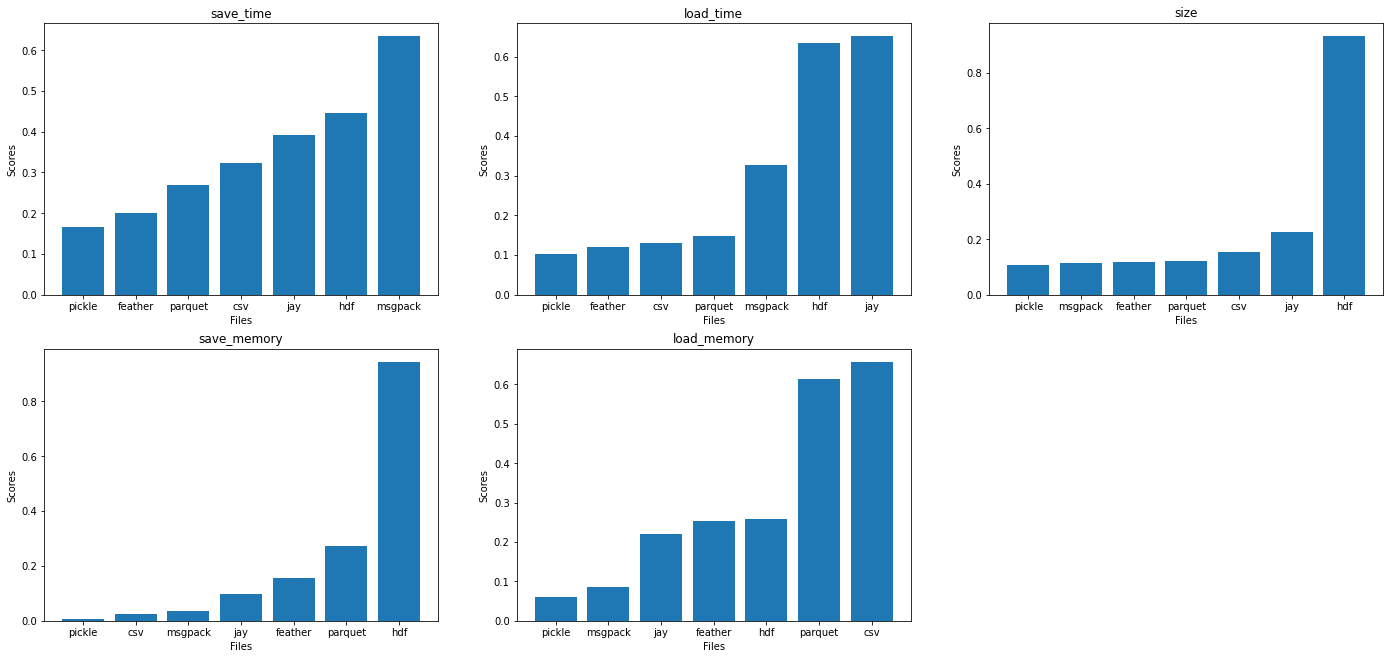

In [ ]:
features(res, 'different types')

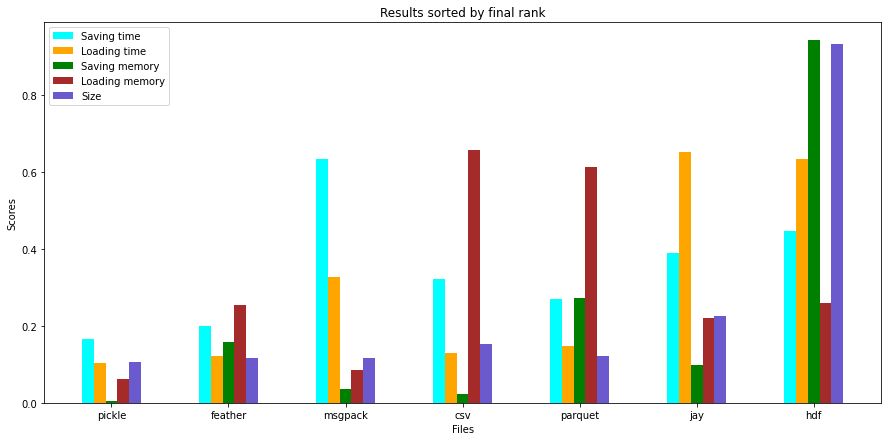

In [ ]:
all_features(res, 'different types')

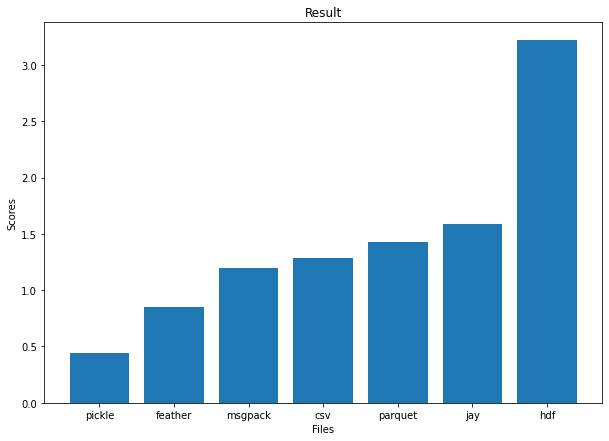

In [ ]:
result_graph(res, 'different types')

<h1>Числовые данные</h1>

In [ ]:
res = final_result('numbers', ['int', 'float'])
res

0 iteration finished
1 iteration finished
2 iteration finished
3 iteration finished
4 iteration finished
5 iteration finished
6 iteration finished
7 iteration finished
8 iteration finished
9 iteration finished


,save_time,load_time,size,save_memory,load_memory,sum,file
6,0.141404,0.126076,0.120104,0.000000,0.000000,0.387585,pickle
4,0.231759,0.202495,0.123310,0.000000,0.000000,0.557564,msgpack
0,0.255317,0.157227,0.214497,0.057454,0.498983,1.183478,csv
1,0.182930,0.131671,0.129411,0.337001,0.422395,1.203409,feather
5,0.259717,0.170167,0.149528,0.302722,0.694649,1.576782,parquet
3,0.207733,0.796613,0.275643,0.108149,0.276003,1.664141,jay
2,0.846780,0.487333,0.899598,0.883059,0.117828,3.234598,hdf


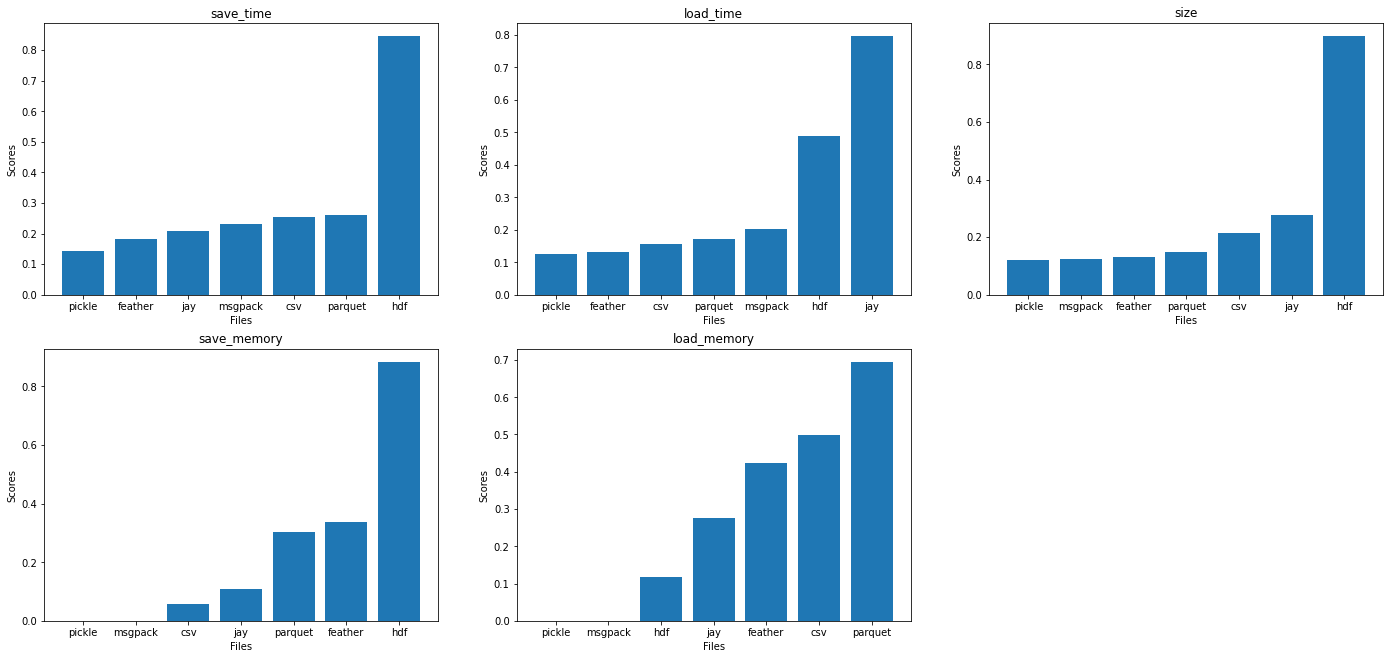

In [ ]:
features(res, 'numbers')

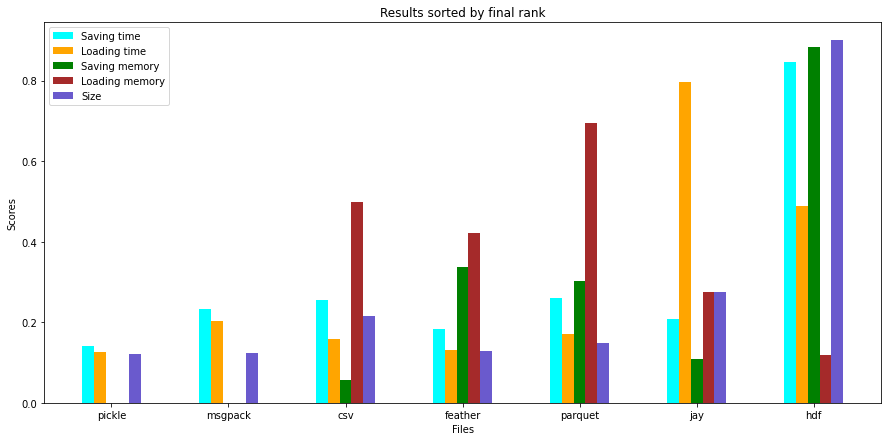

In [ ]:
all_features(res, 'numbers')

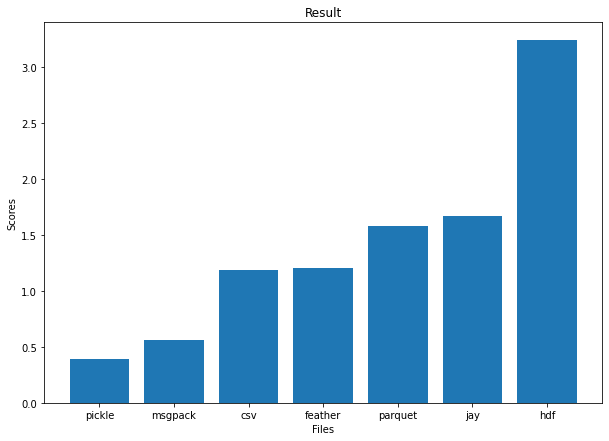

In [ ]:
result_graph(res, 'numbers')

<h1>Данные нечисловых типов</h1>

In [ ]:
res = final_result('not_numbers', ['string', 'boolean', 'datetime64[ns]'])
res

0 iteration finished
1 iteration finished
2 iteration finished
3 iteration finished
4 iteration finished
5 iteration finished
6 iteration finished
7 iteration finished
8 iteration finished
9 iteration finished


,save_time,load_time,size,save_memory,load_memory,sum,file
6,0.130548,0.086574,0.091200,0.089876,0.000000,0.398199,pickle
0,0.347659,0.112227,0.105340,0.234223,0.041306,0.840754,csv
1,0.161635,0.117990,0.103213,0.298226,0.314091,0.995156,feather
4,0.629223,0.410327,0.105850,0.000000,0.310107,1.455507,msgpack
3,0.460754,0.600223,0.193420,0.165454,0.095821,1.515672,jay
5,0.208777,0.132649,0.096967,0.623007,0.827791,1.889191,parquet
2,0.429140,0.647887,0.954942,0.657731,0.330236,3.019936,hdf


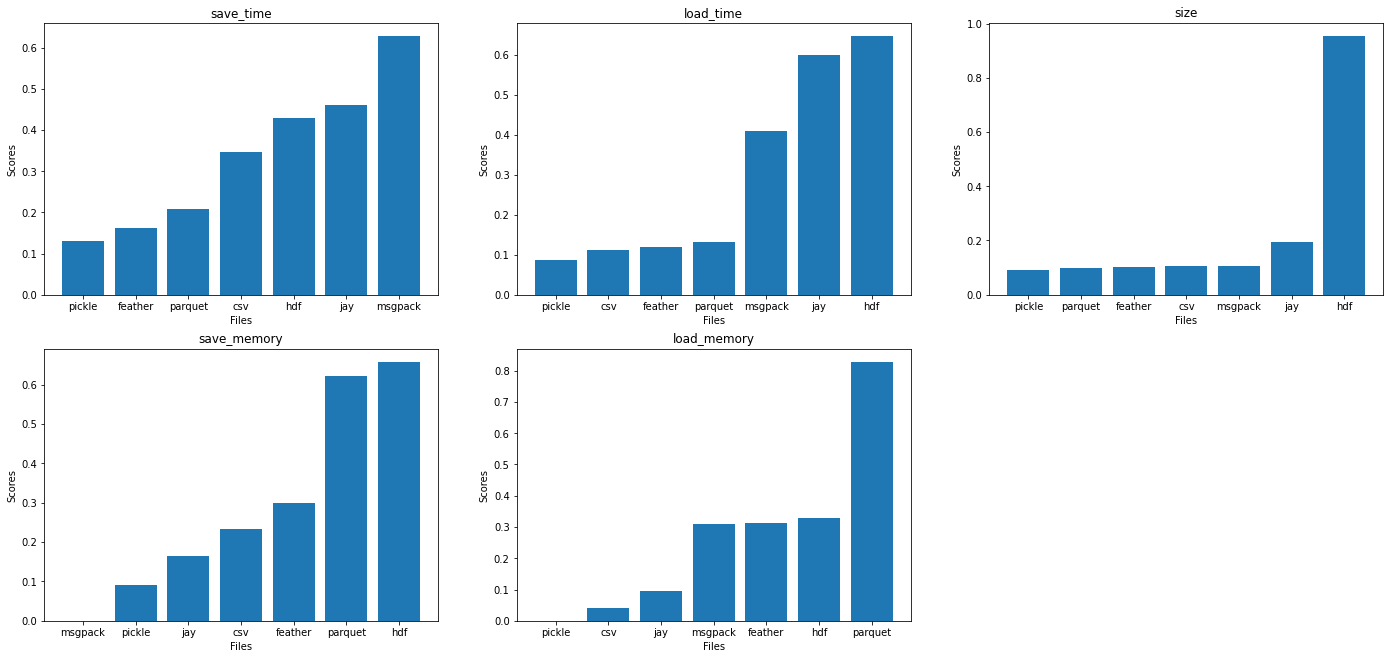

In [ ]:
features(res, 'not_numbers')

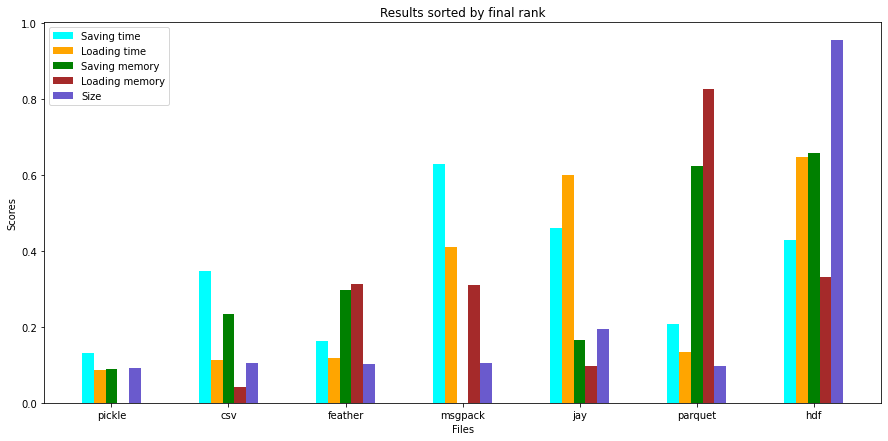

In [ ]:
all_features(res, 'not_numbers')

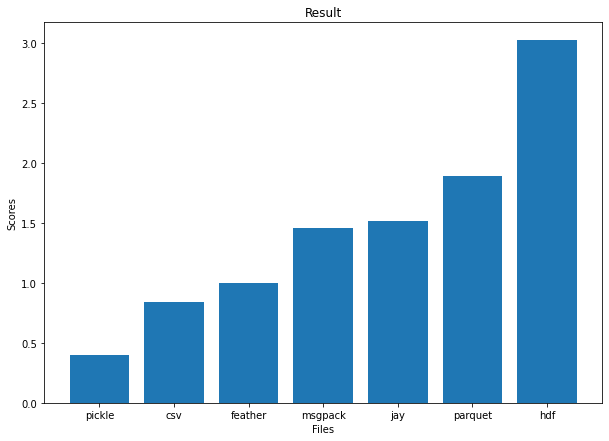

In [ ]:
result_graph(res, 'not_numbers')